# Prediction

In [1]:
from pyspark import SparkContext
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

import json
import utils
import pprint
pp = pprint.PrettyPrinter(indent=4)

sc = SparkContext("local[*]", "ADA")
sc.defaultParallelism

8

# Importing the data

In [2]:
rdd_features = sc.textFile('data/spark/features/').map(json.loads).map(lambda x: x['features'])
print(rdd_features.count())
rdd_features.first()

49344


{'firstProblemGrade': 9.68999958038,
 'increaseGradeFromFirstToLastProblem': 1.0,
 'lastProblemGrade': 10.0,
 'percentageImprovedBetweenFirstAndLastProblem': 0.9999677430196963,
 'proportionOfProblemEvents': 0.03389830508474576,
 'repeatedVideoBeforeFirstProblem': 1.0,
 'timeBetweenFirstAndLastProblem': 0.009236111111111112,
 'timeBetweenStartAndFirstProblem': 8.520023148148148,
 'timeBetweenStartAndLastProblem': 8.529259259259259,
 'totalNumberOfProblemSubmissions': 2,
 'totalNumberOfVideoWatched': 26,
 'watchedAllVideosBeforeFirstProblem': True,
 'watchedSomeVideoAfterFirstProblem': 0.0}

In [3]:
df = pd.DataFrame(rdd_features.collect())
df.head()

,firstProblemGrade,increaseGradeFromFirstToLastProblem,lastProblemGrade,percentageImprovedBetweenFirstAndLastProblem,proportionOfProblemEvents,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,totalNumberOfProblemSubmissions,totalNumberOfVideoWatched,watchedAllVideosBeforeFirstProblem,watchedSomeVideoAfterFirstProblem
0,9.69,1.0,10.0,0.999968,0.033898,1.0,0.009236,8.520023,8.529259,2,26,True,0.0
1,10.00,0.0,10.0,0.000000,0.015152,1.0,0.000000,4.715845,4.715845,1,57,True,0.0
2,10.00,0.0,10.0,0.000000,0.010526,1.0,0.000000,6.102060,6.102060,1,94,True,0.0
3,9.58,1.0,10.0,0.999976,0.039216,1.0,0.005590,2.375741,2.381331,2,49,True,0.0
4,7.09,1.0,10.0,0.999997,0.750000,0.0,6.030475,5.967859,11.998333,9,3,True,0.0


In [4]:
FEATURES = df.columns
FEATURES

Index(['firstProblemGrade', 'increaseGradeFromFirstToLastProblem',
       'lastProblemGrade', 'percentageImprovedBetweenFirstAndLastProblem',
       'proportionOfProblemEvents', 'repeatedVideoBeforeFirstProblem',
       'timeBetweenFirstAndLastProblem', 'timeBetweenStartAndFirstProblem',
       'timeBetweenStartAndLastProblem', 'totalNumberOfProblemSubmissions',
       'totalNumberOfVideoWatched', 'watchedAllVideosBeforeFirstProblem',
       'watchedSomeVideoAfterFirstProblem'],
      dtype='object')

In [5]:
FEATURES_MEAN = {}
FEATURES_STD = {}
for feature in FEATURES:
    FEATURES_MEAN[feature]=df[feature].mean()
    FEATURES_STD[feature]=df[feature].std()

# Random forest 

In [6]:
RF_FEATURES = [f for f in FEATURES if not f in [
    'lastProblemGrade',
    'percentageImprovedBetweenFirstAndLastProblem', 
    'increaseGradeFromFirstToLastProblem'
]]

dataRF = (rdd_features
    .filter(lambda x: x['totalNumberOfProblemSubmissions']>1 and x['firstProblemGrade']<10)
    .map(lambda x: [x[feature] for feature in RF_FEATURES])
).collect()

print(dataRF[0])

[9.68999958038, 0.03389830508474576, 1.0, 0.009236111111111112, 8.520023148148148, 8.529259259259259, 2, 26, True, 0.0]


In [7]:
labelsRF = (rdd_features
    .filter(lambda x: x['totalNumberOfProblemSubmissions']>1 and x['firstProblemGrade']<10)
    .map(lambda x: x['lastProblemGrade']==10.)
).collect()

print(labelsRF[:10])
print(sum(labelsRF)/len(labelsRF))

[True, True, True, True, True, True, True, True, False, False]
0.7533275791577704


In [8]:
def getSplit(data,labels,proportion):
    n = int(proportion * len(data))
    Xtrain = data[:n]
    Ytrain = labels[:n]
    Xtest = data[n:]
    Ytest = labels[n:]
    return(Xtrain,Ytrain,Xtest,Ytest)

In [9]:
parameters = [2,4,8,12,16,24,32,48,64]

In [10]:
def computeScores(predictions,y):
    measures = [ 
        (
            'TP' if (predictions[index] and y[index]) else
            'FP' if (predictions[index] and not y[index]) else 
            'TN' if (not predictions[index] and not y[index]) else 
            'FN'
        
        )
        for index in range(len(y))
    ]
    TP = sum([measure == 'TP' for measure in measures])
    FP = sum([measure == 'FP' for measure in measures])
    TN = sum([measure == 'TN' for measure in measures])
    FN = sum([measure == 'FN' for measure in measures])
    
    scores = {}
    scores['TPr'] = TP / ( TP + FN )
    scores['TNr'] = TN / ( TN + FP )
    
    scores['accuracy'] = ( TP + TN ) / ( TP + TN + FP + FN )
    
    scores['precision'] = TP / ( TP + FP )
    scores['recall'] = TP / ( TP + FN )
    
    p = scores['precision']
    r = scores['recall']
    scores['Fscore'] = 2. * p * r / ( p + r )
    
    return scores

In [11]:
trainScores = []
testScores = []
for param in parameters: 
    (Xtrain,Ytrain,Xtest,Ytest) = getSplit(dataRF,labelsRF,0.8)
    clf = RandomForestClassifier(n_estimators=param,class_weight='balanced_subsample')
    clf.fit(Xtrain,Ytrain)
    
    testScore = computeScores(clf.predict(Xtest),Ytest)
    trainScore = computeScores(clf.predict(Xtrain),Ytrain)
    
    print(testScore)
    print(computeScores([True for _ in Ytest],Ytest))
    print()
    
    trainScores.append(trainScore)
    testScores.append(testScore)

{'accuracy': 0.6547808312514195, 'precision': 0.8302169035153328, 'recall': 0.6755934266585514, 'TPr': 0.6755934266585514, 'Fscore': 0.7449664429530202, 'TNr': 0.5935541629364369}
{'accuracy': 0.7463093345446287, 'precision': 0.7463093345446287, 'recall': 1.0, 'TPr': 1.0, 'Fscore': 0.8547275328391208, 'TNr': 0.0}

{'accuracy': 0.7101975925505337, 'precision': 0.8109529702970297, 'recall': 0.7976262933657943, 'TPr': 0.7976262933657943, 'Fscore': 0.80423442773857, 'TNr': 0.4529991047448523}
{'accuracy': 0.7463093345446287, 'precision': 0.7463093345446287, 'recall': 1.0, 'TPr': 1.0, 'Fscore': 0.8547275328391208, 'TNr': 0.0}

{'accuracy': 0.7426754485578015, 'precision': 0.8101411696917314, 'recall': 0.8557516737674985, 'TPr': 0.8557516737674985, 'Fscore': 0.8323220364066893, 'TNr': 0.41002685765443153}
{'accuracy': 0.7463093345446287, 'precision': 0.7463093345446287, 'recall': 1.0, 'TPr': 1.0, 'Fscore': 0.8547275328391208, 'TNr': 0.0}

{'accuracy': 0.7501703384056325, 'precision': 0.80226

In [12]:
dfTestScores = pd.DataFrame(testScores)
dfTrainScores = pd.DataFrame(trainScores)
dfTestScores.head()

,Fscore,TNr,TPr,accuracy,precision,recall
0,0.744966,0.593554,0.675593,0.654781,0.830217,0.675593
1,0.804234,0.452999,0.797626,0.710198,0.810953,0.797626
2,0.832322,0.410027,0.855752,0.742675,0.810141,0.855752
3,0.840626,0.359893,0.882836,0.750170,0.802268,0.882836
4,0.847428,0.360788,0.895009,0.759482,0.804651,0.895009


In [13]:
feature_importances = clf.feature_importances_

for index in sorted(range(len(RF_FEATURES)),key=(lambda i: feature_importances[i]),reverse= True):
    feature = RF_FEATURES[index]
    print(feature + (40-len(feature))*' ',feature_importances[index])


firstProblemGrade                        0.282151260337
timeBetweenFirstAndLastProblem           0.16557569436
timeBetweenStartAndLastProblem           0.159058659256
timeBetweenStartAndFirstProblem          0.130725775467
proportionOfProblemEvents                0.104070556808
totalNumberOfVideoWatched                0.0900482498727
totalNumberOfProblemSubmissions          0.0391852775217
watchedAllVideosBeforeFirstProblem       0.0107063205617
repeatedVideoBeforeFirstProblem          0.00988705369154
watchedSomeVideoAfterFirstProblem        0.00859115212478


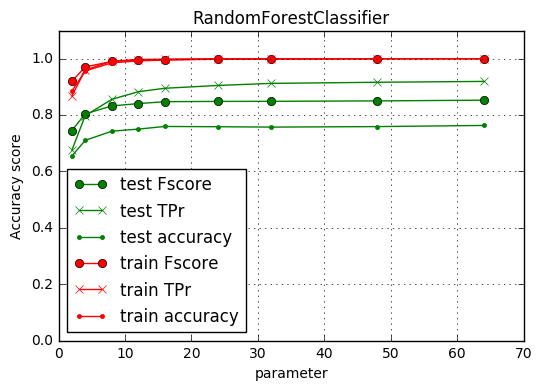

In [14]:
f, ax = plt.subplots(1)
plt.title("RandomForestClassifier")
plt.xlabel("parameter")
plt.ylabel("Accuracy score")
plt.grid()
ax.set_ylim(ymin=0,ymax=1.1)
plt.plot(parameters, dfTestScores.Fscore, 'o-', color="g", label="test Fscore")
plt.plot(parameters, dfTestScores.TPr, 'x-', color="g", label="test TPr")
plt.plot(parameters, dfTestScores.accuracy, '.-', color="g", label="test accuracy")

plt.plot(parameters, dfTrainScores.Fscore, 'o-', color="r", label="train Fscore")
plt.plot(parameters, dfTrainScores.TPr, 'x-', color="r", label="train TPr")
plt.plot(parameters, dfTrainScores.accuracy, '.-', color="r", label="train accuracy")

plt.legend(loc="best")

plt.show()

# Logistic Regression

In [15]:
LR_FEATURES = [f for f in FEATURES if not f in [
    'lastProblemGrade',
    'percentageImprovedBetweenFirstAndLastProblem', 
    #'firstProblemGrade', 
    'increaseGradeFromFirstToLastProblem',
    ''
]]

dataLR = (rdd_features
    .filter(lambda x: x['totalNumberOfProblemSubmissions']>1 and x['firstProblemGrade']<10)
    .map(lambda x: [(x[feature]-FEATURES_MEAN[feature])/FEATURES_STD[feature] for feature in LR_FEATURES])
).collect()

print(dataLR[0])

[0.4158665459555137, -0.6299229124757464, 0.6349530291348382, -0.15382463910599103, 0.6599079925314141, 0.5323300262459776, 0.12557275969019144, -0.10784988792772118, 0.57578436303778735, -0.20088152823181604]


In [16]:
labelsRF = (rdd_features
    .filter(lambda x: x['totalNumberOfProblemSubmissions']>1 and x['firstProblemGrade']<10)
    .map(lambda x: x['lastProblemGrade']==10.)
).collect()

print(labelsRF[:10])
print(sum(labelsRF)/len(labelsRF))

[True, True, True, True, True, True, True, True, False, False]
0.7533275791577704


In [17]:
parameters = [0.0001,0.001,0.01,0.1,1,10]

In [18]:
trainScores = []
testScores = []
for param in parameters: 
    (Xtrain,Ytrain,Xtest,Ytest) = getSplit(dataRF,labelsRF,0.8)
    clf = linear_model.SGDClassifier(alpha=param, loss='log')
    clf.fit(Xtrain,Ytrain)
    
    testScore = computeScores(clf.predict(Xtest),Ytest)
    trainScore = computeScores(clf.predict(Xtrain),Ytrain)
    
    print(testScore)
    print()
    
    trainScores.append(trainScore)
    testScores.append(testScore)

{'accuracy': 0.7447195094253918, 'precision': 0.7710631895687061, 'recall': 0.9357881923311017, 'TPr': 0.9357881923311017, 'Fscore': 0.8454770415177345, 'TNr': 0.18263205013428827}

{'accuracy': 0.7374517374517374, 'precision': 0.7694838056680162, 'recall': 0.9254412659768716, 'TPr': 0.9254412659768716, 'Fscore': 0.8402873722022659, 'TNr': 0.18442256042972247}

{'accuracy': 0.7542584601408131, 'precision': 0.7731779871095686, 'recall': 0.9491783323189288, 'TPr': 0.9491783323189288, 'Fscore': 0.8521857923497268, 'TNr': 0.18084153983885407}

{'accuracy': 0.7410856234385647, 'precision': 0.7633775159548355, 'recall': 0.9464394400486914, 'TPr': 0.9464394400486914, 'Fscore': 0.8451086956521738, 'TNr': 0.1369740376007162}

{'accuracy': 0.7429025664319782, 'precision': 0.7494210282538212, 'recall': 0.9847839318320146, 'TPr': 0.9847839318320146, 'Fscore': 0.8511309836927932, 'TNr': 0.03133393017009848}

{'accuracy': 0.7435839200545082, 'precision': 0.7487889273356402, 'recall': 0.9878271454656

In [19]:
dfTestScores = pd.DataFrame(testScores)
dfTrainScores = pd.DataFrame(trainScores)
dfTestScores.head()

,Fscore,TNr,TPr,accuracy,precision,recall
0,0.845477,0.182632,0.935788,0.744720,0.771063,0.935788
1,0.840287,0.184423,0.925441,0.737452,0.769484,0.925441
2,0.852186,0.180842,0.949178,0.754258,0.773178,0.949178
3,0.845109,0.136974,0.946439,0.741086,0.763378,0.946439
4,0.851131,0.031334,0.984784,0.742903,0.749421,0.984784


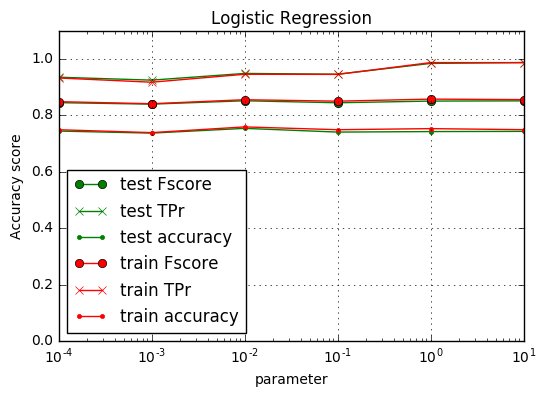

In [20]:
f, ax = plt.subplots(1)
plt.title("Logistic Regression")
plt.xlabel("parameter")
plt.ylabel("Accuracy score")
plt.grid()
ax.set_ylim(ymin=0,ymax=1.1)
plt.semilogx(parameters, dfTestScores.Fscore, 'o-', color="g", label="test Fscore")
plt.semilogx(parameters, dfTestScores.TPr, 'x-', color="g", label="test TPr")
plt.semilogx(parameters, dfTestScores.accuracy, '.-', color="g", label="test accuracy")

plt.semilogx(parameters, dfTrainScores.Fscore, 'o-', color="r", label="train Fscore")
plt.semilogx(parameters, dfTrainScores.TPr, 'x-', color="r", label="train TPr")
plt.semilogx(parameters, dfTrainScores.accuracy, '.-', color="r", label="train accuracy")

plt.legend(loc="best")

plt.show()